# Inspiration
- DALL-E - for generating pictures
- [practical data ethics](https://ethics.fast.ai/) course
- [meta learning](https://radekosmulski.com/the-post-tech-job-manifesto/)
- fastai is a library built on top of PyTorch

# Jupyter Notebook 101
- shift+enter to run cell
- cell starting with exclamation point is a bash command
- In the first cell, make sure to get the latest version of fastai. U flag is for upgrade, q flag is for quiet.`!pip install -Uqq fastai`

# What can machine learning do?
- Natural Language Processing (NLP)
- Computer vision
- Medicine
- Biology
- Image generation
- Recommendation systems
- Playing games
- Robotics

If a human can do it reasonably quickly, then that is probably something that deep learning can do.Arthur Samuel is one of the fathers of machine learning. 

# Birds Exercise
- We want to build a model that can recognize what is a bird and not a bird from photos.
- Images are represented by pixels (numbers).

## Steps
1. Download images from DuckDuckGo of birds and non-birds (forests).
2. Train the model - i.e. fine-tune a pretrained neural network to recognise these two groups.
3. Try running the model and see if it works.

In [139]:
import time
from duckduckgo_search import DDGS 
import fastcore.all as fc 
from fastdownload import download_url
import fastai.vision.all as fv
import fastai.tabular.all as ft
import fastai.collab as f_collab
import fastbook as fb

def search_images(keywords, max_images=200): return fc.L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [141]:
# if you ever have questions about a fastai method, use the function doc
fb.doc(download_url)

# Step 1: Download images 
- download images from DuckDuckGo search engine of birds and non-birds
- for non-birds, let's search for forests; because we can't search duckduckgo for non-bird
- remove images that failed to download correctly

getting a bird photo
len(urls)=1, urls[0]='https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'


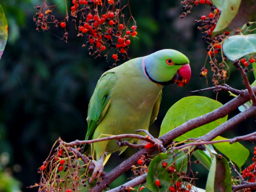

In [142]:
# get a bird photo
print("getting a bird photo")
urls = search_images('bird photos', max_images=1)  # search for image in duck duck go search engine
print(f'{len(urls)=}, {urls[0]=}')

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)
im = fv.Image.open(dest)
im.to_thumb(256, 256)

getting a forest photo


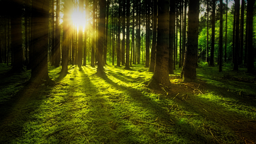

In [143]:
# get a forest photo
print("getting a forest photo")
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=True)
im = fv.Image.open('forest.jpg')
im.to_thumb(256, 256)

In [144]:
searches = 'forest', 'bird'
path = fc.Path('bird_or_not')

if path.exists():
    print("images downloaded already")
else:
    print("downloading images...")
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        # for fastai download_images function, provide a list of urls, does this quickly in parallel
        fv.download_images(dest, urls=search_images(f'{o} photo'))
        time.sleep(5)
        # for computer vision models, you don't need big images
        fv.resize_images(path/o, max_size=400, dest=path/o)  # image no bigger than 400x400 pixels

images downloaded already


In [145]:
# remove images that failed to download correctly
# fv.get_image_files() is a function that returns a list of image files based on extension
failed = fv.verify_images(fv.get_image_files(path))  # path is Path object bird_or_not directory
failed.map(fc.Path.unlink)  # functional style
print(f'{len(failed)=}')


len(failed)=0


# Step 2: Train the model
- create a DataLoaders object, this contains a training set and a validation set
- use a pre-traimed computer vision model, resnet18, and fine-tune it. resenet is pretrained on imagenet with 1 million images covering 1000 categories.
- `fastai` comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model. fine tuning means adjusting the model's weights a little bit so that the model learns to recognize this new dataset. 
- reference [docs.fast.ai](https://docs.fast.ai/) for tutorials and underlying data information
- refrence [Pytorch Image Models (timm)](https://timm.fast.ai/). any of these models can be used in the fastai learner

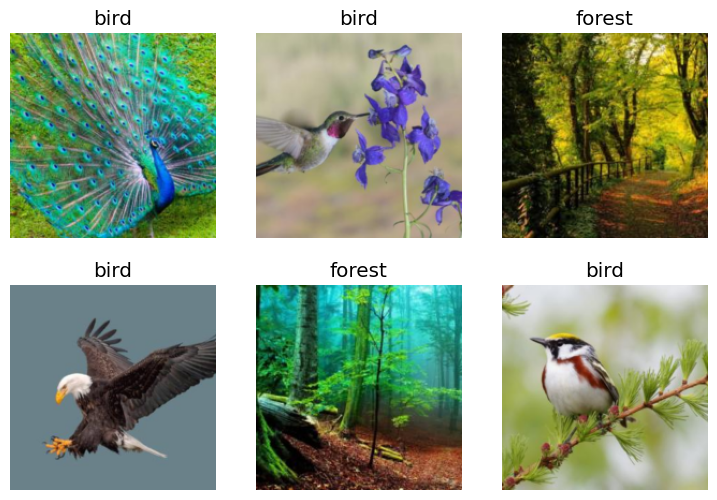

In [146]:
# how to get data into the model?
dls = fv.DataBlock(
    blocks = (fv.ImageBlock, fv.CategoryBlock),  # imputs to model are images and outputs are categories 'bird' and 'forest' 
    get_items = fv.get_image_files,  # to get all the inputs, run the get_image_files function, which returns a list of all image files in the path
    splitter = fv.RandomSplitter(valid_pct=0.2, seed=42),  # randomly split data into 80% training and 20% validation
    get_y = fv.parent_label,  # the labels (y values) is the name of the parent of each file, aka name of folder that images are in, 'bird' or 'forest'
    # item_tfms stands for item transforms, the transforms run on every image in the dataset; computer vision model meeds all the images to be of the same size
    item_tfms = [fv.Resize(192, method='squash')],  # before training, resize each image to 192x192 pixels by squishing (as opposed to cropping) 
).dataloaders(path, bs=32)

# show_batch() shows a batch of data that will be passed into the model
# it tells you 2 things: 1) the input (the picture), and 2) the label
dls.show_batch(max_n=6)

In [147]:
# learner - comnbines a model and data to train the model
# the model is the neural netowrk function - you can use any one of the Pytorch Image Models (timm)
# model resnet18 should be fine for most purposes, fun to try different models
# fastai donwloads the weights of the pre-trained model for you
learn = fv.vision_learner(dls, fv.resnet18, metrics=fv.error_rate)
learn.fine_tune(3)  # 3 epochs
# fine_tune() takes those pre-trained weights, and adjust them 
# to teach the model the difference between your dataset and what it was originally trained for

epoch,train_loss,valid_loss,error_rate,time
0,0.744032,0.250158,0.071429,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.075697,0.028537,0.014286,00:02
1,0.060600,0.016215,0.000000,00:02
2,0.040455,0.038533,0.014286,00:02


# Step 3: Use the model

In [148]:
category_string, category_integer, probs = learn.predict(fv.PILImage.create('bird.jpg'))
print(f'{len(probs)=}')
print(f'{probs.shape=}')
print('---')
print('looking at bird.jpg')
print(f'This is a: {category_string}')
print(f'Integer category: {category_integer}')
print(f'Probability it\'s a bird: {probs[0]:.4f}')
print(f'Probability it\'s a forest: {probs[1]:.4f}')

len(probs)=2
probs.shape=torch.Size([2])
---
looking at bird.jpg
This is a: bird
Integer category: 0
Probability it's a bird: 0.9981
Probability it's a forest: 0.0019


In [149]:
category_string, category_integer, probs = learn.predict(fv.PILImage.create('forest.jpg'))
print('looking at forest.jpg')
print(f'This is a: {category_string}')
print(f'Integer category: {category_integer}')
print(f'Probability it\'s a bird: {probs[0]:.4f}')

looking at forest.jpg
This is a: forest
Integer category: 1
Probability it's a bird: 0.0000


# Segmentation
- segmentation - a model that can recognize the content of every individual pixel in an image

epoch,train_loss,valid_loss,time
0,2.970022,2.144104,00:02


epoch,train_loss,valid_loss,time
0,1.595070,1.504382,00:03
1,1.487417,1.506119,00:03
2,1.429634,1.288083,00:04
3,1.307553,1.101965,00:04
4,1.184394,1.031177,00:04
5,1.072281,0.931492,00:04
6,0.975659,0.918516,00:04
7,0.901235,0.913283,00:04


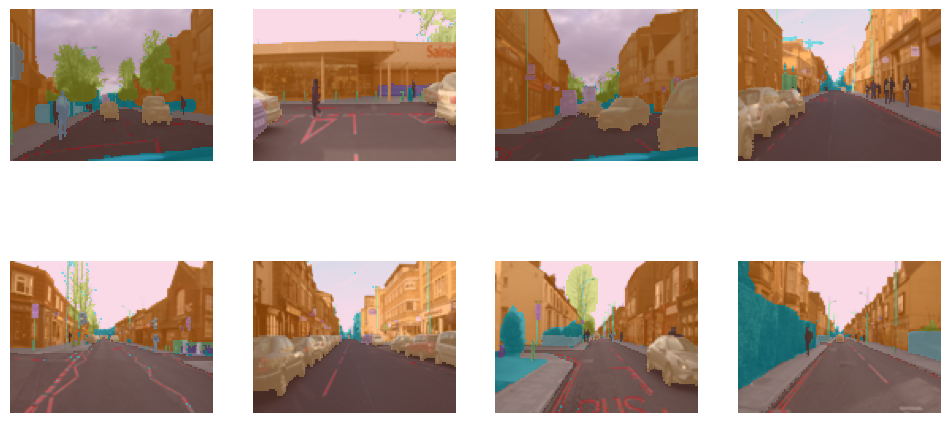

In [150]:
# untar_data: a thin wrapper for FastDownload.get
# downloads and extracts by default to subdirectories of ~/.fastai
# returns the path to the extracted data
# reference: https://docs.fast.ai/data.external.html#untar_data
# CAMVID_TINY: A tiny camvid dataset for segmentation type models. 
# reference: https://docs.fast.ai/data.external.html

path_seg = fv.untar_data(fv.URLs.CAMVID_TINY)
fnames_seg = fv.get_image_files(path_seg/'images')
def label_func_seg(o): return path_seg/'labels'/f'{o.stem}_P{o.suffix}'
codes_seg = fv.np.loadtxt(path_seg/'codes.txt', dtype=str) 

dls_seg = fv.SegmentationDataLoaders.from_label_func(
    path_seg,  # path to put in dataloaders 
    fnames_seg,
    label_func_seg,
    bs=8,  # size of batch
    codes = codes_seg,  # what does each code mean in text file
)
dls_seg.show_batch()

learn_seg = fv.unet_learner(dls_seg, fv.resnet34)
learn_seg.fine_tune(8)

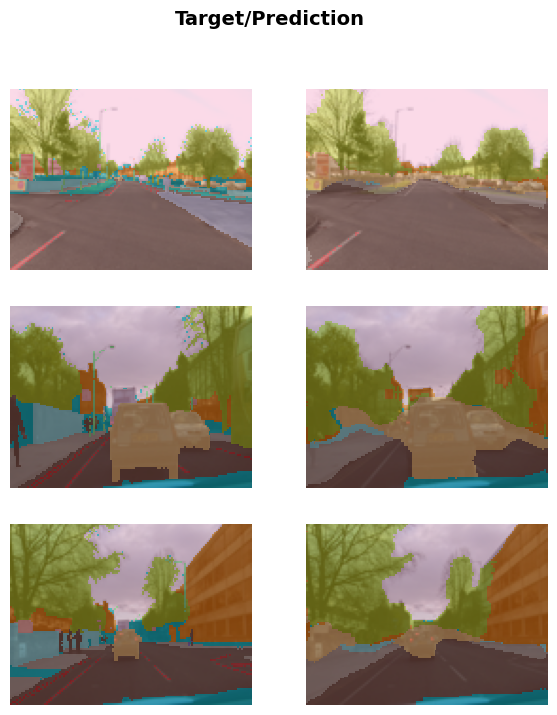

In [151]:
learn_seg.show_results(max_n=3, figsize=(7,8))

# Tabular Anaylsis

## Income Prediciton Example

In [ ]:
# untar_data: downloads some data and decompresses it for you
# URLs: urls provided by fastai for common data sets
path_inc = ft.untar_data(ft.URLs.ADULT_SAMPLE)

dls_inc = ft.TabularDataLoaders.from_csv(
    path_inc/'adult.csv',
    path = path_inc, 
    y_names = "salary",
    # tell the dataloader which of the categories are categorical
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship'],
    # tell the dataloader which of the categories are continuous, aka can take any real number
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [ft.Categorify, ft.FillMissing, ft.Normalize]
)

dls_inc.show_batch()

In [156]:
learn_inc = ft.tabular_learner(dls_inc, metrics=ft.accuracy)
learn_inc.fit_one_cycle(2)
# there is no pretrained model for this, so we don't use fine_tune()
# use fit_one_cycle() when training fastai models from scratch

epoch,train_loss,valid_loss,accuracy,time
0,0.375112,0.379544,0.824631,00:04
1,0.359812,0.357903,0.832617,00:04


In [157]:
learn_inc.show_results()

,workclass,education,marital-status,occupation,relationship,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,12.0,3.0,15.0,1.0,1.0,1.647258,0.404334,-0.421062,1.0,0.0
1,5.0,10.0,3.0,13.0,1.0,1.0,-0.039554,-0.892654,1.146278,1.0,1.0
2,5.0,10.0,5.0,13.0,2.0,1.0,-0.992970,0.422846,1.146278,0.0,0.0
3,5.0,16.0,6.0,7.0,2.0,1.0,-0.699611,0.809626,-0.029227,0.0,0.0
4,5.0,9.0,3.0,14.0,1.0,1.0,-0.699611,0.519524,0.362608,0.0,0.0
5,5.0,15.0,3.0,11.0,1.0,1.0,-0.186234,0.548736,1.929948,1.0,1.0
6,7.0,12.0,3.0,5.0,1.0,1.0,1.940616,-0.136403,-0.421062,0.0,0.0
7,5.0,16.0,5.0,9.0,4.0,1.0,-1.506347,-0.354379,-0.029227,0.0,0.0
8,8.0,12.0,5.0,2.0,2.0,1.0,0.327144,-0.683058,-0.421062,0.0,0.0


# Collaborative Filtering - Recommendation System
- collaborative filtering is the basis of recommendation systems today
- we take a dataset that says which users liked/used which products and use that to guess what other products that user may like based on finding similar ussers and those similar users like
- similar users means users who liked the same kind of products
- for example, you tell Spotify what you like and then Spotify recommends more like that

In [161]:
# download and decompress data
path_collab = f_collab.untar_data(f_collab.URLs.ML_SAMPLE)  # this is the movie lens sample
dls_collab = f_collab.CollabDataLoaders.from_csv(path_collab/'ratings.csv')
dls_collab.show_batch()
# collaborative filtering data generally has a userid, some product id like movieid, and a rating

,userId,movieId,rating
0,306,165,4.0
1,306,2762,3.0
2,213,2762,2.5
3,472,595,5.0
4,607,1198,4.0
5,547,592,1.0
6,247,1036,5.0
7,514,50,5.0
8,407,5952,4.0
9,430,2571,4.0


In [162]:
# input data and possible range for real number 1-5
# it's good to extend the range a little bit, little lower and little higher 0.5-5.5
learn_collab = f_collab.collab_learner(dls_collab, y_range=(0.5,5.5))
learn_collab.fine_tune(10)
# loss is the "mean squared error" i.e. on average how far off are we

epoch,train_loss,valid_loss,time
0,1.495095,1.383233,00:00


epoch,train_loss,valid_loss,time
0,1.365676,1.327463,00:00
1,1.281270,1.166520,00:00
2,1.037276,0.885061,00:00
3,0.796667,0.748380,00:00
4,0.679044,0.716274,00:00
5,0.650943,0.703286,00:00
6,0.616990,0.701770,00:00
7,0.592189,0.698353,00:00
8,0.609543,0.696911,00:00
9,0.607564,0.696754,00:00


In [163]:
learn_collab.show_results()

,userId,movieId,rating,rating_pred
0,94.0,23.0,2.5,3.054126
1,98.0,22.0,5.0,4.221479
2,27.0,64.0,3.5,3.751903
3,16.0,69.0,4.0,4.199093
4,94.0,43.0,3.5,3.596240
5,19.0,74.0,5.0,3.872680
6,29.0,61.0,5.0,4.350070
7,75.0,48.0,3.0,4.158607
8,9.0,24.0,2.5,3.144753


# Chapter 1: Intro
- from [Deep Learning for Coders with fastai and PyTorch](https://course.fast.ai/Resources/book.html)

## Machine Learning
- Machine Learning is the training of programs developed by allowing a computer to learn from its experience, rather than through manually coding the individual steps.
- deep learning is a modern area in the more general machine learning that uses neural networks with multiple layers
- positive feedback loop: where the more the model is used, the more biased the data becomes, making the model even more biased
- A classification model is one which attempts to predict a class, or category. It's predicting from a number of discrete possibilities. 
- A regression model is one which attempts to predict one or more numeric quantities, such as a temperature or a location. 

## Overfitting
- overfitting - you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset!
- overfitting occurs when validation accuracy gets worse during training
- "a challenging issue when training for all machine learning practitioners, and all algorithms"

## Neural Network
- "regard a neural network as a mathematical function, it turns out to be a function which is extremely flexible depending on its weights"
- stochastic gradient descent (SGD) - a completely general way to update the weights of a neural network automatically
- CNN (Convolutional Neural Network) structure is inspired by how the human vision system works
- resnet34 is a standard architecture where 34 refers to number of layers.Models using architectures with more layers take longer to train, and are more prone to overfitting. On the other hand, when using more data, they can be quite a bit more accurate.
- metric like error_rate - what percentage of images in the validation set are being classified incorrectly. metric is for humans
- loss - define a "measure of performance" that the training system can use to update weights automatically
- transfer learning - Using a pretrained model for a task different to what it was originally trained for
- Fine-tuning - transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

training a model


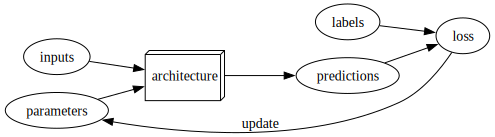

In [164]:
print("training a model")
fb.gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

## Classifier - to recognize dogs and cats



In [166]:
# untar_data downloads a standard dataset from the fast.ai datasets collection (if not previously downloaded) to your server, 
# extracts it (if not previously extracted), and returns a Path object with the extracted location
path_pets = fv.untar_data(fv.URLs.PETS)

# is_cat function: labels cats based on a filename rule
# i.e. The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise
def is_cat(x): return x[0].isupper()  

# from_name_func means that labels can be extracted using a function applied to the filename
dls_pets = fv.ImageDataLoaders.from_name_func(
    path_pets,
    fv.get_image_files(path_pets),
    valid_pct = 0.2,  # hold out 20% of the data (for validation) and not use it for training the model at all. By default, the 20% that is held out is selected randomly
    seed = 42,
    label_func = is_cat,  # tell fastai how to get the labels from the dataset, i.e. the filename here
    item_tfms = fv.Resize(224),  # define transforms, resize to 224, standard size for historical reasons
    # item_tfms are applied to each item
    # batch_tfms are applied to a batch of items at a time using the GPU
)

# create a convolutional neural network (CNN) and specify:
# 1. what architecture to use (i.e. what kind of model to create), 
# 2. what data we want to train it on, and 
# 3. what metric to use
# vision_learner pretrained parameter defaults to True
learn_pets = fv.vision_learner(dls_pets, fv.resnet34, metrics=fv.error_rate)
# provide: number of epochs
# use 1 epoch to fit jus to get new random head working corretcly, head is the new last layer of the adjusted model
learn_pets.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.387918,0.244374,0.112652,03:59


epoch,train_loss,valid_loss,error_rate,time
0,0.236891,0.186605,0.080514,05:59


learn_pets.loss=None


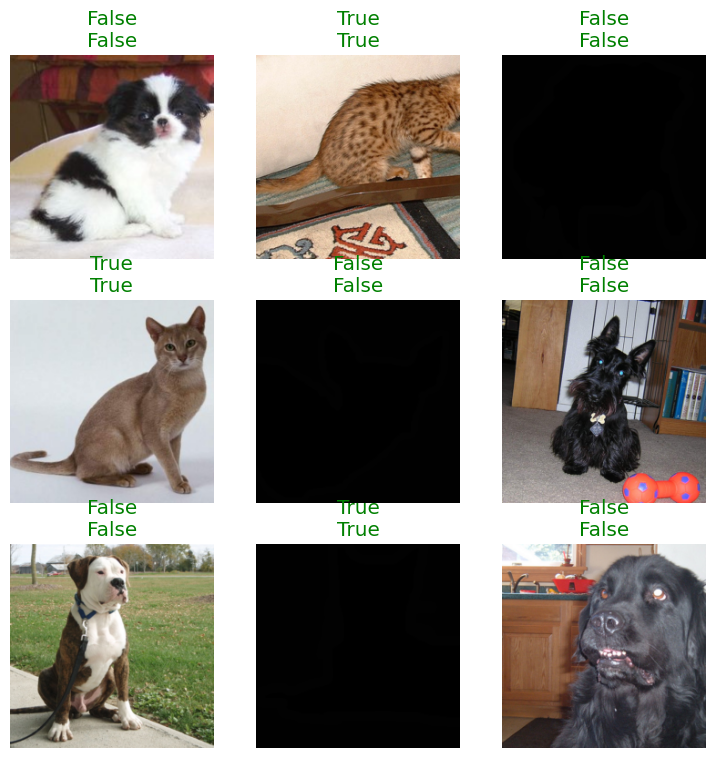

In [167]:
# fastai will always show you your model's accuracy using only the validation set, never the training set
print(f'{learn_pets.loss=}')
learn_pets.show_results()

getting a cat photo
images downloaded already


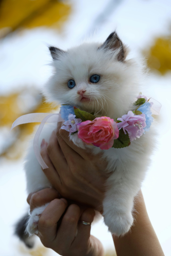

In [168]:
print("getting a cat photo")
urls_cats = search_images('cat photos', max_images=1)  # search for image in duck duck go search engine
dest_cat = 'cat.jpg'
if fc.Path(dest_cat).exists():
    print("images downloaded already")
else:
    print("downloading images...")
    download_url(urls_cats[0], dest_cat, show_progress=True)
img_cat = fv.Image.open(dest_cat)
img_cat.to_thumb(256, 256)

In [169]:
is_cat, _, probs = learn_pets.predict(img_cat)
print("is this a cat?", is_cat)
print(f'Probability that this is a cat: {probs[1].item():.6f}')

is this a cat? True
Probability that this is a cat: 1.000000


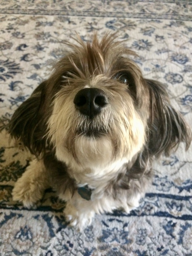

In [170]:
img_turing = fv.Image.open('turing.JPG')
img_turing.to_thumb(256, 256)

In [171]:
is_cat, _, probs = learn_pets.predict(img_turing)
print("is this a cat?", is_cat)
print(f'Probability that this is a cat: {probs[1].item():.6f}')

is this a cat? False
Probability that this is a cat: 0.002198


# training, validation, test sets
- Just as the automatic training process is in danger of overfitting the training data, we are in danger of overfitting the validation data through human trial and error and exploration
- training set - used to train the model
- validation set - used to determine hyperparameters
- test set - used evaluate the model at the very end of the efforts
- a key property of the validation and test sets is that they must be representative of the new data you will see in the future
- so look at a few examples, sometimes splitting randomly is not the best approach